# Steady-state and step response

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cghiaus/dm4bem_book/HEAD?labpath=%2Ftutorials%2F02_2_2Toy.ipynb)

[Steady-state](https://en.m.wikipedia.org/wiki/Steady_state) analysis focuses on the behavior of a system after transients have settled, specifically when the system reaches a stable equilibrium at a constant input.

[Step response](https://en.m.wikipedia.org/wiki/Step_response) analyses system's dynamic response to a sudden change in input (i.e., to a step input). Step response is concerned with  transient behavior, such as how the system responds immediately after the input change and how it eventually settles into a new steady-state.

**Objectives:**
- Find the steady-state values for thermal circuit and state-space.
- Estimate the time step and the setthing time from eigenvalue analysis.
- Simulate the step response.
- Compare the steady-state results with step response after settling time.

![thermal_circuit](../figures/03_therm_circ.svg)
> Figure 1. Thermal circuit for the cubic building.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

The following assumptions are done:
- The indoor air temperature is controlled or not (i.e., the building is in free running).
- The heat capacity of air and of glass is neglected or not.
- The time step is calculated from the eigenvalues or it is imposed at a value designated as $\Delta t$.

In [2]:
controller = False
neglect_air_glass_capacity = False
imposed_time_step = False
Δt = 498    # s, imposed time step

The thermal circuit was described in the section on modelling (Figure 1). It is given by a _thermal circuit_ imported from the file [./toy_model/TC.csv](./toy_model/TC.csv). 

A thermal ciruit file contains the incidence matrix $A$, the diagonals of matrices $G$ and $C$, and the vectors $b$, $f$, and $y$ (see example below). If there is no value in a cell, it is considered `0`.

In [3]:
print('Matrices and vectors for thermal circuit from Figure 1') 
df = pd.read_csv('./toy_model/TC_0.csv')
df.style.apply(lambda x: ['background-color: yellow'
                          if x.name in df.index[-3:] or c in df.columns[-2:]
                          else '' for c in df.columns], axis=1)

Matrices and vectors for thermal circuit from Figure 1


,A,θ0,θ1,θ2,θ3,θ4,θ5,θ6,θ7,G,b
0,q0,1,0.000000,0,0,0,0,0,0,1125.000000,To
1,q1,-1,1.000000,0,0,0,0,0,0,630.000000,0
2,q2,0,-1.000000,1,0,0,0,0,0,630.000000,0
3,q3,0,0.000000,-1,1,0,0,0,0,30.375000,0
4,q4,0,0.000000,0,-1,1,0,0,0,30.375000,0
5,q5,0,0.000000,0,0,-1,1,0,0,44.786824,0
6,q6,0,0.000000,0,0,-1,0,1,0,360.000000,0
7,q7,0,0.000000,0,0,0,-1,1,0,72.000000,0
8,q8,0,0.000000,0,0,0,0,0,1,165.789474,To
9,q9,0,0.000000,0,0,0,1,0,-1,630.000000,0


In the thermal circuit [./toy_model/TC.csv](./toy_model/TC.csv), the controller is _off_, i.e., the gain of the proportional controller is 0, $K_p = G_{11} = 0$; the building is in _free-floating_. The controller may be turned _on_ by setting $K_p = G_{11} \rightarrow \infty$.

In [4]:
# MODEL
# =====
# Thermal circuit
TC = dm4bem.file2TC('./toy_model/TC.csv', name='', auto_number=False)

# by default TC['G']['q11'] = 0, i.e. Kp -> 0, no controller (free-floating)
if controller:
    TC['G']['q11'] = 1e3        # Kp -> ∞, almost perfect controller

if neglect_air_glass_capacity:
    TC['C']['θ6'] = TC['C']['θ7'] = 0
    # or
    TC['C'].update({'θ6': 0, 'θ7': 0})

Thermal circuit is transformed in state-space representation.

In [5]:
# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

## Steady-state analysis
[Steady-state](https://en.m.wikipedia.org/wiki/Steady_state) means that in the system of differential-algebraic equations (DAE):

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

or in the state-space representation,

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_s + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

the term $\dot \theta = 0$, i.e., the temperatures do not vary in time.

In [steady-state](https://en.m.wikipedia.org/wiki/Steady_state), the model can be checked if it is incorrect. Let's consider that:
- the controller is not active, $K_p \rightarrow 0$,
- the outdoor temperature is $T_o = 10 \, \mathrm{^\circ C}$,
- the indoor temperature setpoint is $T_{i,sp} = 20 \, \mathrm{^\circ C}$,
- all flow rate sources are zero.

In [6]:
bss = np.zeros(12)        # temperature sources b for steady state
bss[[0, 8, 10]] = 10      # outdoor temperature
bss[[11]] = 20            # indoor set-point temperature

fss = np.zeros(8)         # flow-rate sources f for steady state

*Note*: Steady-state analysis is a test of [falsification (refutability)](https://en.m.wikipedia.org/wiki/Falsifiability) of the model, not a [verification and validation](https://en.m.wikipedia.org/wiki/Verification_and_validation). If the model does not pass the steady-state test, it means that it is wrong. If the model passes the steady-state test, it does not mean that it is correct. For this example, the values of the capacities in matrix $C$ or of the conductances in matrix $G$ can be wrong, even when the steady-state test is passed. 

### Steady-state from differential algebraic equations (DAE)

The temperature values in [steady-state](https://en.m.wikipedia.org/wiki/Steady_state) are obtained from the system of DAE by considering that $C \dot{\theta} = 0$:

$$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$

For the conditions mentioned above, in steady-state, all temperatures $\theta_0 ... \theta_7,$ including the indoor air temperature $\theta_6,$ are equal to $T_o = 10 \, \mathrm{^\circ C}$ (Figure 1).

In [7]:
A = TC['A']
G = TC['G']
diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

θss = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θss = {np.around(θss, 2)} °C')

θss = [10. 10. 10. 10. 10. 10. 10. 10.] °C


If the sum auxiliary heat sources in the room, $\dot Q_a = f_6$, is not zero, the temperature in the room $\theta_6$ has the highest value and the temperature of the outdoor surface of the wall $\theta_0$ is almost equal to the outdoor temperature, $T_o = b_0$.

In [8]:
bss = np.zeros(12)        # temperature sources b for steady state

fss = np.zeros(8)         # flow-rate sources f for steady state
fss[[6]] = 1000

θssQ = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θssQ = {np.around(θssQ, 2)} °C')

θssQ = [ 0.14  0.39  0.65  5.88 11.12  5.57 12.26  4.41] °C


### Steady-state from state-space representation
The input vector $u$ of the state-space representation is obtained by stacking the vectors $b_T$ and $f_Q$:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- $b_T$ is a vector of the nonzero elements of vector $b$ of temperature sources. For the circuit presented in Figure 1, $b_T = [T_o, T_o, T_o, T_{i,sp}]^T$ corresponding to branches 0, 8, 10 and 11, where:
    - $T_o$ - outdoor temperature, °C;
    - $T_{i,sp}$ - set-point temperaure for the indoor air, °C.
- $f_Q$ - vector of nonzero elements of vector $f$ of flow sources. For the circuit presented in Figure 1, $f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$, corresponding to nodes 0, 4, 6, and 7, where:
    - $\Phi_o$ - solar radiation absorbed by the outdoor surface of the wall, W;
    - $\Phi_i$ - solar radiation absorbed by the indoor surface of the wall, W;
    - $\dot{Q}_a$ - auxiliary heat gains (i.e., occupants, electrical devices, etc.), W;
    - $\Phi_a$ - solar radiation absorbed by the glass, W.

*Note*: Zero in vectors $b$ and $f$ indicates that there is no source on the branch or in the node, respectively. However, a source can have the value zero.

In [9]:
bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
uss = np.hstack([bT, fQ])           # input vector for state space
print(f'uss = {uss}')

uss = [10 10 10 20  0  0  0  0]


The steady-state value of the output of the state-space representation is obtained when $\dot \theta_{C} = 0$:

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [10]:
inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yss = (-Cs @ inv_As @ Bs + Ds) @ uss

yss = float(yss.values)
print(f'yss = {yss:.2f} °C')

yss = 10.00 °C


The error between the steady-state values obtained from the system of DAE, $\theta_6$, and the output of the state-space representation, $y_{ss}$, 

$$\varepsilon = \left | \theta_6 - y_{ss} \right |$$

is practically zero; the slight difference is due to [numerical errors](https://en.m.wikipedia.org/wiki/Numerical_error).

In [11]:
print(f'Error between DAE and state-space: {abs(θss[6] - yss):.2e} °C')

Error between DAE and state-space: 3.55e-15 °C


Likewise, the steady-state of the output of the state-space representation for input $\dot Q_a$ is obtained from

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [12]:
bT = np.array([0, 0, 0, 0])         # [To, To, To, Tisp]
fQ = np.array([0, 0, 1000, 0])      # [Φo, Φi, Qa, Φa]
uss = np.hstack([bT, fQ])

inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yssQ = (-Cs @ inv_As @ Bs + Ds) @ uss

yssQ = float(yssQ.values)
print(f'yssQ = {yssQ:.2f} °C')

yssQ = 12.26 °C


The steady-state values obtained from DAE and state-space representation are pratically equal. 

In [13]:
print(f'Error between DAE and state-space: {abs(θssQ[6] - yssQ):.2e} °C')

Error between DAE and state-space: 3.55e-15 °C


## Eigenvalues analysis

Let's consider the eigenvalues $\lambda$ of the state matrix $A_s$.

In [14]:
# Eigenvalues analysis
λ = np.linalg.eig(As)[0]        # eigenvalues of matrix As

### Time step

The condition for [numerical stability](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) of [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) method is

$$\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$

i.e., in the [complex plane](https://en.m.wikipedia.org/wiki/Complex_plane), $\lambda_i \Delta t$ is inside a circle of radius 1 centered in {-1, 0 j}, where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ - time step,
- $j = \sqrt {-1}$ - [imaginary unit](https://en.m.wikipedia.org/wiki/Imaginary_unit).

For positive real eigenvalues $\left \{ \lambda \in \Re |\lambda >0  \right \}$, which is the case of thermal networks, the above condition [becomes](http://www.math.iit.edu/~fass/478578_Chapter_4.pdf)

$$- \lambda_i \Delta t - 1  < 1, \forall \lambda_i, $$

or

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = 
2 \min \left ( -\frac{1}{\lambda_i}  \right ) = 
2 \min T_i$$

where $T_i$ are the [time constants](https://en.m.wikipedia.org/wiki/Time_constant), $T_i = - \frac{1}{\lambda_i}$. Let's chose a time step smaller than $\Delta t_{max} = \min (-2 / \lambda_i) $.

In [15]:
# time step
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dm4bem.print_rounded_time('dtmax', dtmax)

if imposed_time_step:
    dt = Δt
else:
    dt = dm4bem.round_time(dtmax)
dm4bem.print_rounded_time('dt', dt)

dtmax = 498 s = 8.3 min
dt = 300 s = 5.0 min


In [16]:
if dt < 10:
    raise ValueError("Time step is too small. Stopping the script.")

### Settling time and duration
The [settling time](https://en.m.wikipedia.org/wiki/Step_response) is roughly 4 times the largest time constant.

In [17]:
# settling time
t_settle = 4 * max(-1 / λ)
dm4bem.print_rounded_time('t_settle', t_settle)

t_settle = 176132 s = 48.9 h


The duration of the simulation needs to be larger than the estimated [settling time](https://en.m.wikipedia.org/wiki/Settling_time). This requires a corresponding number of time steps in the time vector.

In [18]:
# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)

duration = 176400 s = 49.0 h


## Step response to outdoor temperature

### Input vector
In dynamic simulation, the inputs are [time series](https://en.m.wikipedia.org/wiki/Time_series), e.g., the oudoor temperature will have $n$ values $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]$ at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

The input vector $u$ of the state-space representation is obtained by stacking the vectors $b_T$ and $f_Q$ of the system of Differential Algebraic Equations:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- vector $b_T$ consists of the nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 1, 

$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &0  &0  &0  &T_o  &0  &T_o  &T_{i,sp} 
\end{matrix}]^T$$

and 

$$b_T = [T_o, T_o, T_o, T_{i,sp}]^T$$

corresponding to branches 0, 8, 10 and 11; 
- vector $f_Q$ is the nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 1,

$$f = [\begin{matrix}
\Phi_o &0  &0  &0  &\Phi_i  &0  &\dot{Q_a} &\Phi_a 
\end{matrix}]^T$$

and

$$f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$$

corresponding to nodes 0, 4, 6, and 7.

For the thermal circuit shown in Figure 1, the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the input vector, $u = [u_0, u_1, ... , u_{n-1}]^T$, is:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_{i,sp}\\ 
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a\\ 
\Phi_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
\Phi_{o(0)} & \Phi_{o(1)} & ... & \Phi_{o(n-1)}\\
\Phi_{i(0)} & \Phi_{i(1)} & ... & \Phi_{i(n-1)}\\ 
\dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}\\ 
\Phi_{a(0)} & \Phi_{a(1)} & ... & \Phi_{a(n-1)}
\end{bmatrix}$$

where:
- $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the oudoor temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

- $T_{i, sp} = [T_{{i, sp}(0)}, T_{{i, sp}(1)}, ..., T_{{i, sp}(n-1)}]$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the setpoint indoor temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

- $\Phi_o = [\Phi_{o(0)}, \Phi_{o(1)}, ..., \Phi_{o(n-1)}]$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the outdoor surface of the wall at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

- $\Phi_i = [\Phi_{i(0)}, \Phi_{i(1)}, ..., \Phi_{i(n-1)}]$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the indoor surface of the wall at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

- $\dot{Q}_a = [\dot{Q}_{a(0)}, \dot{Q}_{a(1)}, ..., \dot{Q}_{a(n-1)}]$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the auxiliary heat gains (i.e., occupants, electrical devices, etc.) at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

- $\Phi_a = [\Phi_{a(0)}, \Phi_{a(1)}, ..., \Phi_{a(n-1)}]$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the glass at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

_Note_: In Pandas [time series](https://pandas.pydata.org/pandas-docs/version/0.9.1/timeseries.html), time is an index. Therefore, Pandas representation of vector of inputs $u$ in time is the transpose of the matrix presented above. 

Let's consider a [step response](https://en.m.wikipedia.org/wiki/Step_response) in the conditions used for steady-state analysis, i.e., $T_o = 10 \, \mathrm{^\circ C}$, $T_{i,sp} = 20 \, \mathrm{^\circ C}$, and all the flow sources zero (including the HVAC system).

In [19]:
# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}S")

To = 10 * np.ones(n)        # outdoor temperature
Ti_sp = 20 * np.ones(n)     # indoor temperature set point
Φa = 0 * np.ones(n)         # solar radiation absorbed by the glass
Qa = Φo = Φi = Φa           # auxiliary heat sources and solar radiation

data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
input_data_set = pd.DataFrame(data, index=time)

# inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

### Time integration

The state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

is integrated in time by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$.

In [20]:
# Initial conditions
θ_exp = pd.DataFrame(index=u.index)     # empty df with index for explicit Euler
θ_imp = pd.DataFrame(index=u.index)     # empty df with index for implicit Euler

θ0 = 0                      # initial temperatures
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])

Then, we obtain the outputs

$$ y = C_s \theta_s + D_s u$$

for explicit and for implicit Euler methods, respectively.

In [21]:
# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

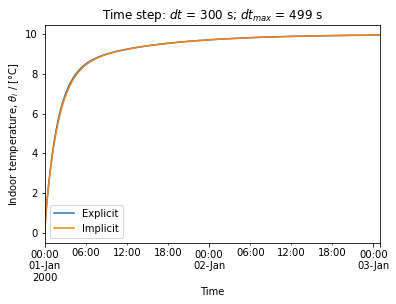

In [22]:
# plot results
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)

ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / [°C]')
ax.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {dtmax:.0f} s')
plt.show()

> Figure 2. Step response to outdoor temperature $T_o$ by using Euler
[implicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method)
and
[explicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration.

The results of explicit and implicit Euler integration are practically identical if $dt < dt_{max}$. If $dt > dt_{max}$, Euler explicit method of integration is numerically unstable.

The value the indoor temperature obtained after the [settling time](https://en.m.wikipedia.org/wiki/Settling_time) is almost equal to the value obtained in steady-state.

In [23]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θss[6]):.4f} °C')
print(f'- state-space model: {float(yss):.4f} °C')
print(f'- steady-state response to step input: \
{y_exp["θ6"].tail(1).values[0]:.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 9.9645 °C


## Step response to internal load

Let's consider that the temperature sources are zero and that the flow-rate sources are zero, with the exception of the auxiliary heat gains, $\dot Q_a$.

In [24]:
# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# Create a DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}S")
# Create input_data_set
To = 0 * np.ones(n)         # outdoor temperature
Ti_sp =  20 * np.ones(n)     # indoor temperature set point
Φa = 0 * np.ones(n)         # solar radiation absorbed by the glass
Φo = Φi = Φa                # solar radiation
Qa = 1000 * np.ones(n)      # auxiliary heat sources
data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
input_data_set = pd.DataFrame(data, index=time)

# Get inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

In [25]:
# Initial conditions
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])

In [26]:
# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

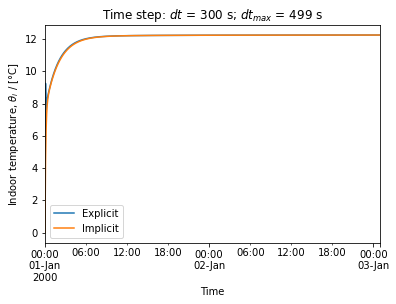

In [27]:
# plot results
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)
ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / [°C]')
ax.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {dtmax:.0f} s')
plt.show()

> Figure 3. Step response to auxiliary heat gains $\dot Q_a$ by using Euler
[implicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method)
and
[explicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration.

In [28]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θssQ[6]):.4f} °C')
print(f'- state-space model: {float(yssQ):.4f} °C')
print(f'- steady-state response to step input: \
{y_exp["θ6"].tail(1).values[0]:.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 12.2566 °C
- state-space model: 12.2566 °C
- steady-state response to step input: 12.2549 °C


## Discussion

### Time step

The time step depends on:
- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and of the glass $C_g =$ `C['Glass']` are considered, then the time step is small;
    - if the capacities of the air and of the glass are zero, then the time step is large (and the order of the state-space model is reduced).
 
- P-controller gain `Kp`:
    - if $K_p \rightarrow \infty$, then the controller is perfect and the time step needs to be small;
    - if $K_p \rightarrow 0$, then, the controller is ineffective and the building is in free-running.

#### Air and glass capacities

In cell `[2]`, consider:

```
controller = False
neglect_air_glass_capacity = False
imposed_time_step = False
```

Note that the maximum time step for numerical stability of explicit Euler integration method is: `dtmax = 499 s = 8.3 min`.

Now, in cell `[2]`, consider:

```
controller = False
neglect_air_glass_capacity = False
imposed_time_step = True
Δt = 498    # s, imposed time step
```

and explain the simulation results.

Determine the number of state variables, $\theta_s$.

In cell `[2]`, consider:

```
controller = False
neglect_air_glass_capacity = True
imposed_time_step = False
```

Note that the maximum time step for numerical stability of explicit Euler integration method is: `dtmax = 9587 s = 2.7 h`. Observe the simulation results, comment and correct them.

Determine the number of state variables, $\theta_s$ and compare with the case in which the capacities of the air and of the glass were considered.

#### Controller gain

The controller models an HVAC system able to mantain setpoint temperature by heating (when $q_{HVAC} > 0$) and by cooling (when $q_{HVAC} < 0$).

In cell `[2]`, consider:

```
controller = True
neglect_air_glass_capacity = True
imposed_time_step = False
```

Maximum time step for numerical stability of explicit Euler integration method is: `dtmax = 8441 s = 2.3 h`. 

Observe, comment and improve the simulation results.

In cell `[2]`, consider:

```
controller = True
neglect_air_glass_capacity = False
imposed_time_step = False
```

Comment on time step and simulation results.

In cell `[4]`:
```
if controller:
    TC['G']['q11'] = 1e3        # Kp -> ∞, almost perfect controller

```

Change the gain of the controller to `1e5` in cell `[4]`:
```
if controller:
    TC['G']['q11'] = 1e5        # Kp -> ∞, almost perfect controller
```
Comment the error raised in cell `[16]`.

## References

1. [C. Ghiaus (2013)](https://doi.org/10.1016/j.energy.2012.10.024). Causality issue in the heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, , open access preprint: [HAL-03605823](https://hal.archives-ouvertes.fr/hal-03605823/document)

2. [C. Ghiaus (2021)](https://doi.org/10.1007/978-3-030-76477-7_5). Dynamic Models for Energy Control of Smart Homes, in *S. Ploix M. Amayri, N. Bouguila (eds.) Towards Energy Smart Homes*, Online ISBN: 978-3-030-76477-7, Print ISBN: 978-3-030-76476-0, Springer, pp. 163-198, open access preprint: [HAL 03578578](https://hal.archives-ouvertes.fr/hal-03578578/document)

3. [J.A. Duffie, W. A. Beckman, N. Blair (2020)](https://www.eng.uc.edu/~beaucag/Classes/SolarPowerForAfrica/Solar%20Engineering%20of%20Thermal%20Processes,%20Photovoltaics%20and%20Wind.pdf). Solar Engineering of Thermal Processes, 5th ed. John Wiley & Sons, Inc. ISBN 9781119540281

4. [Réglementation Thermique 2005. Méthode de calcul Th-CE.](https://pdfslide.fr/documents/rt2005-methode-de-calcul-th-ce.html). Annexe à l’arrêté du 19 juillet 2006

5. H. Recknagel, E. Sprenger, E.-R. Schramek (2013) Génie climatique, 5e edition, Dunod, Paris. ISBN 978-2-10-070451-4

6. [J.R. Howell et al. (2021)](http://www.thermalradiation.net/indexCat.html). Thermal Radiation Heat Transfer 7th edition, ISBN 978-0-367-34707-0, A Catalogue of Configuration Factors

7. [J. Widén, J. Munkhammar (2019)](http://www.diva-portal.org/smash/get/diva2:1305017/FULLTEXT01.pdf). Solar Radiation Theory, Uppsala University